In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re
import netCDF4 as nc

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))


from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.viewer_2d import *
from code_comparison.code_comparison import *
from files.load_plasma_files						import load_plasma_files
from gridtools.solps_python_scripts.read_b2fgmtry import *

from soledge.mk_funcs import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


In [2]:
from wrapper_class import *

In [57]:
path=os.path.join(path = r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19")
# path=os.path.join(path = r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19")

self = SOLEDGEcase(path)
# wall_fluxes = self.get_wall_fluxes()


# Data on tri

In [65]:
Nm == np.array([])

ValueError: operands could not be broadcast together with shapes (5707,) (0,) 

ValueError: operands could not be broadcast together with shapes (5707,) (0,) 

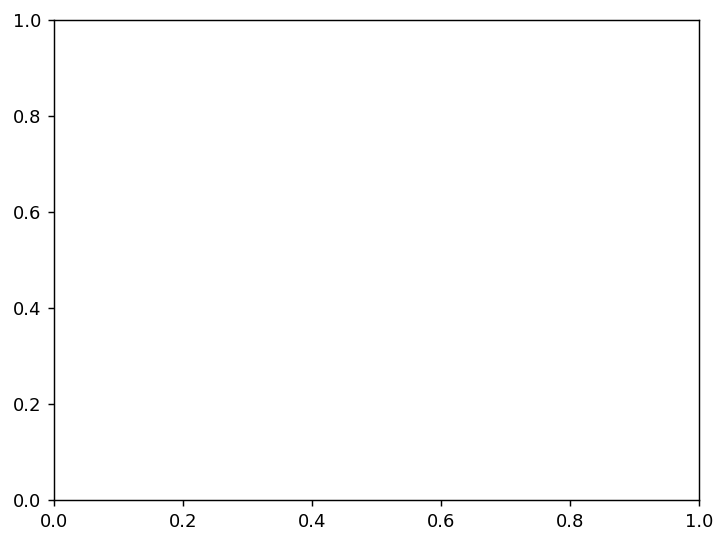

In [63]:
Nm = self._get_2d_on_tri("Nmi")
Nn = self._get_2d_on_tri("Nni")
frac = Nm /(Nn + Nm)

Nm.shape

fig, ax = plt.subplots(dpi = 130)

self.plot_2d(data = frac, ax = ax)

ax.set_aspect("equal")

# Wall neutrals

In [38]:
from files.load_eirene_triangles				import load_eirene_triangles
from eirene.get_wall_triangle					import get_wall_triangle

path = r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"
Eirene = load_eirene_triangles(os.path.join(path,"triangles.h5"))

ZeroTriangle, ZeroSide, Ri, Zi, RWallTriangles, ZWallTriangles, iWallTriangles, iWallSide, iWallKnots  = \
				get_wall_triangle(Eirene, rz0_line=[0,0], theta_line=0, no_plot=1, no_print=1, no_triangles=0)

RWallTriangles = np.append(RWallTriangles, RWallTriangles[0])
ZWallTriangles = np.append(ZWallTriangles, ZWallTriangles[0])
iWallKnots	   = np.append(iWallKnots, iWallKnots[0])

WalldL  	   = np.sqrt((RWallTriangles[1:]-RWallTriangles[:-1])**2 + (ZWallTriangles[1:]-ZWallTriangles[:-1])**2)
DistKnots	   = np.cumsum(np.append(0., WalldL))
DistTriangles  = 0.5*(DistKnots[:-1]+DistKnots[1:])

load_eirene_triangles: reading file  C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19\triangles.h5
wall_segments
wall_segments: completed
	h5_read: error reading:  /walls_eirene_external/nExtWalls
	h5_read: error reading:  surfaces/nSurfaces
load_eirene_triangles: Completed
get_wall_triangle
get_wall_triangles
get_wall_triangles.2: Completed
get_wall_triangle: Completed


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


In [43]:
RefPar = self.RefPar
ions = self.ions
Eirene = self.Eirene

evolution = 0

if(evolution == 0):
    base_plasma_name = path+"/Results/"
else:
    base_plasma_name = path+"/Evolution/{:d}_".format(evolution)

if_plasma	= h5py.File(base_plasma_name+"plasma_0", "r")
Te			= h5_read(if_plasma,"triangles/temperature")*RefPar.T0eV
if_plasma.close()

if_plasma	= h5py.File(base_plasma_name+"plasma_1", "r")
Ti			= h5_read(if_plasma,"triangles/temperature")*RefPar.T0eV
if_plasma.close()

Te 	= Te[iWallKnots]
Ti 	= Ti[iWallKnots]

In [44]:
for iPlasma in range(len(ions)):
    try:
        if_plasma	= h5py.File(base_plasma_name+"plasma_"+str(iPlasma), "r")
    except:
        break

    temperature	= h5_read(if_plasma,"triangles/temperature")*RefPar.T0eV
    density		= h5_read(if_plasma,"triangles/density")*RefPar.n0
    velocity	= h5_read(if_plasma,"triangles/velocity")*RefPar.c0

    temperature = temperature[iWallKnots]
    density 	= density[iWallKnots]
    velocity 	= velocity[iWallKnots]

    Jsat		= np.abs(1.6022e-19*velocity*density)*1e-3											#eletronic charge
    M			= velocity/np.sqrt((Te+Ti)/2)*(np.sqrt(RefPar.T0eV)/RefPar.c0)	
    
    
    if(iPlasma > 0):
        try:
            Sn_tri	= h5_read(if_plasma,"triangles/Sn")*RefPar.n0/RefPar.tau0
            if(Sn_tri.max() - Sn_tri.min() > 0.):
                Sn_tri = set_min_positive(Sn_tri)
                Sn	   = Sn_tri[iWallTriangles]
                Sn	   = 0.5*np.append(np.append(Sn[0]+Sn[-1], Sn[:-1]+Sn[1:]), Sn[0]+Sn[-1])
#					print("Sn.min(), Sn.max()",Sn.min(), Sn.max())
            else: Sn = 0.
            Sn_tri = 0
#				Sn	= -h5_read(if_plasma,"triangles/Sn")*RefPar.n0/RefPar.tau0									#recombination
        except:
            print("plot1d_wall_ntmpi: Sn is not available")
            Sn  = 0.

        try:
            Nn = eirene_neutrals["atomic_species"]["dens_1"][:]
            Tn = eirene_neutrals["atomic_species"]["T_1"][:]
            Nm = eirene_neutrals["molecular_species"]["dens_1"][:]
            Tm = eirene_neutrals["molecular_species"]["T_1"][:]
            
            Nn = Nn[iWallTriangles]
            Nm = Nm[iWallTriangles]
            Tn = Tn[iWallTriangles]
            Tm = Tm[iWallTriangles]

            Tn = set_min_positive(Tn)
            Tm = set_min_positive(Tm)
            Nn	= 0.5*np.append(np.append(Nn[0]+Nn[-1], Nn[:-1]+Nn[1:]), Nn[0]+Nn[-1])*RefPar.n0
            Nm	= 0.5*np.append(np.append(Nm[0]+Nm[-1], Nm[:-1]+Nm[1:]), Nm[0]+Nm[-1])*RefPar.n0
            Tn	= 0.5*np.append(np.append(Tn[0]+Tn[-1], Tn[:-1]+Tn[1:]), Tn[0]+Tn[-1])
            Tm	= 0.5*np.append(np.append(Tm[0]+Tm[-1], Tm[:-1]+Tm[1:]), Tm[0]+Tm[-1])

            Pn	= (Nn*Tn+Nm*Tm)*1.6e-19
            if(Pn.max() - Pn.min() < 0.): Pn = 0.
        except:
            raise Exception("Cannot read neutral data")
    else:
        Sn	= 0.; Pn	= 0.
        
        

,iTri,iSide,iProp,dlSurf,dlWall,Area,R,Z,F_Ion_Incident,F_Atom_Emitted_from_Ion,...,E_incident_Electron,E_incident_Ions,E_Total,E_incident_Atoms,E_Radiation_Atoms,E_Rad_Recombination,E_Recombination_in_Wall,E_incident_Molecules,E_incident_Ions_EIRENE,E_Radiation
0,5662.0,3.0,4.0,4.026479,4.026479,0.051736,0.167577,0.021120,0.0,0.0,...,0.0,0.0,10510.185,4398.1187,6108.5131,0.0,3.552800,0.0,0.0,6108.5131
1,5646.0,3.0,4.0,0.049309,0.049309,0.051941,0.167650,-0.028094,0.0,0.0,...,0.0,0.0,10508.672,4412.5367,6092.1176,0.0,4.017619,0.0,0.0,6092.1176
2,5645.0,3.0,4.0,0.098600,0.098600,0.052281,0.168808,-0.077380,0.0,0.0,...,0.0,0.0,11090.007,4960.1782,6125.7124,0.0,4.116365,0.0,0.0,6125.7124
3,5644.0,3.0,4.0,0.147625,0.147625,0.052683,0.171030,-0.126479,0.0,0.0,...,0.0,0.0,13767.581,7603.7263,6159.0823,0.0,4.772237,0.0,0.0,6159.0823
4,5643.0,3.0,4.0,0.196079,0.196079,0.053090,0.174384,-0.175103,0.0,0.0,...,0.0,0.0,13952.106,7667.2766,6279.3029,0.0,5.525980,0.0,0.0,6279.3029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,5667.0,3.0,4.0,3.787921,3.787921,0.049686,0.182364,0.256188,0.0,0.0,...,0.0,0.0,19677.897,12954.6090,6713.7553,0.0,9.532745,0.0,0.0,6713.7553
249,5666.0,3.0,4.0,3.833066,3.833066,0.050372,0.177582,0.212193,0.0,0.0,...,0.0,0.0,15559.998,9085.4483,6467.2142,0.0,7.335286,0.0,0.0,6467.2142
250,5665.0,3.0,4.0,3.880363,3.880363,0.051589,0.173600,0.166155,0.0,0.0,...,0.0,0.0,14933.240,8554.4800,6371.9365,0.0,6.823779,0.0,0.0,6371.9365
251,5664.0,3.0,4.0,3.928568,3.928568,0.051648,0.170522,0.118503,0.0,0.0,...,0.0,0.0,12986.077,6758.4125,6222.5217,0.0,5.143212,0.0,0.0,6222.5217


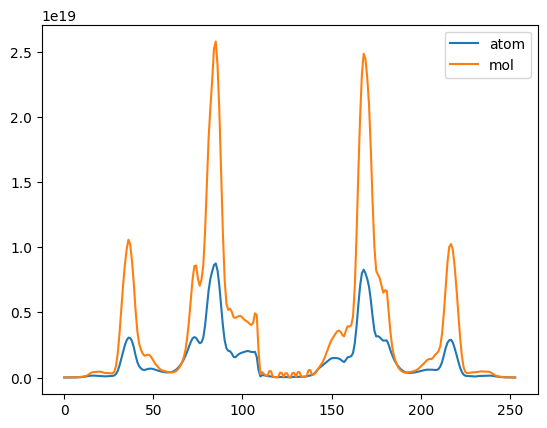

In [50]:
plt.plot(Nn, label = "atom")
plt.plot(Nm, label = "mol")
plt.legend()

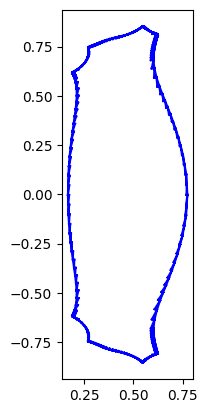

In [15]:
fig, ax = plt.subplots()
plt.triplot(RKnots, ZKnots, WallTriKnots, 'b-')
ax.set_aspect("equal")

In [37]:
iWallTriangles.shape

(253,)

In [18]:
eirene_neutrals = h5py.File(os.path.join(path, "Results", "eirene_neutrals"), 'r')
plasma1 = h5py.File(os.path.join(path, "Results", "plasma_1"), 'r')

Ne = plasma1["triangles"]["density"][:]
Ti = plasma1["triangles"]["temperature"][:]
Nn = eirene_neutrals["atomic_species"]["dens_1"][:]
Tn = eirene_neutrals["atomic_species"]["T_1"][:]

print(eirene_neutrals["atomic_species"].keys())
# eirene_neutrals.close()
# plasma1.close()

# Ne = Ne[iWallKnots]
# Nn = Nn[iWallKnots]
# Tn = Tn[iWallKnots]
# Ti = Ti[iWallKnots]

<KeysViewHDF5 ['T_1', 'Vx_1', 'Vy_1', 'Vz_1', 'dens_1', 'strata_1', 'strata_2', 'strata_3', 'strata_4', 'strata_5', 'strata_6', 'strata_7', 'strata_8', 'symbol_1']>


In [25]:
self.Eirene.__dict__.keys()

dict_keys(['Eirene_OK', 'Triangles', 'WallTriangles', 'KnotsInterp', 'RKnots', 'ZKnots', 'Wall', 'ToTheCenter', 'Surfaces'])

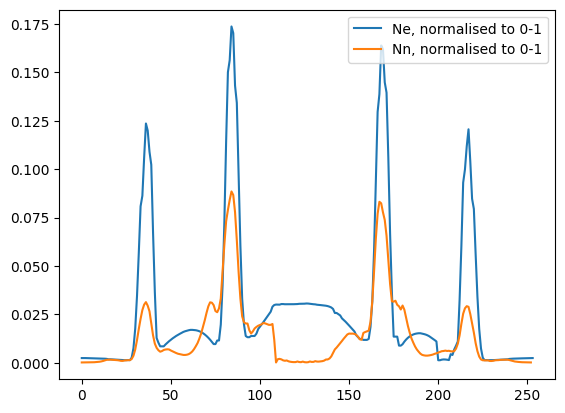

In [22]:
plt.plot(Ne[iWallKnots], label = "Ne, normalised to 0-1")
plt.plot(Nn[iWallTriangles], label = "Nn, normalised to 0-1")
plt.legend()

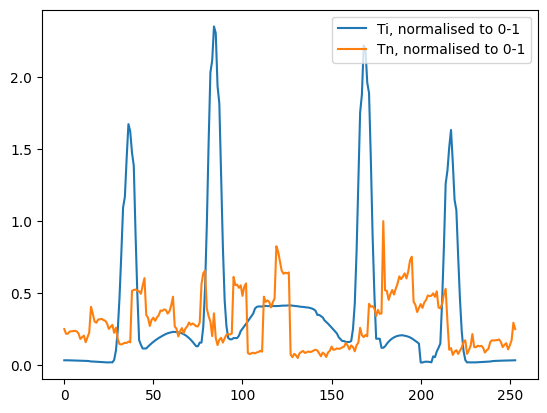

In [63]:
plt.plot(Ne/np.max(Ti), label = "Ti, normalised to 0-1")
plt.plot(Tn/np.max(Tn), label = "Tn, normalised to 0-1")
plt.legend()

In [17]:
T = f["atomic_species"]["T_1"]
T[iWallKnots]

TypeError: Indexing elements must be in increasing order

In [16]:
try:
    AFluxF	 = np.loadtxt(os.path.join(self.path, "soledge2D.atoms_fluxes_wall_1"), dtype='f8')
#            		[0:iTri, 1:iSide, 2:iProp, 3:dlWall, 
#					 4:Flux_Atom_Incident, 			5:Flux_Mol_Incident,
#					 6:Flux_Atom_Emitted_from_Ion, 	7:Flux_Mol_Emitted_from_Ion,
#					 8:Flux_Atom_Emitted_from_Atom, 9:Flux_Mol_Emitted_from_Atom]
except:
    print("\tError: Not found "+ self.path+"soledge2D.atoms_fluxes_wall_1")
    exit()

In [12]:
from eirene.get_wall_triangle					import get_wall_triangle

In [19]:
ZeroTriangle, ZeroSide, Ri, Zi = get_wall_triangle(self.Eirene, rz0_line=[0,0], theta_line=0, no_plot=1, no_print=1)

R = self.R
Z = self.Z
TriKnots = self.TriKnots

iTri	= AFluxF[:,0]-1 										#Matlab/Fortan to python indexes
iSide	= AFluxF[:,1]-1 										#Matlab/Fortan to python indexes
WallL	= AFluxF[:,3]


Vertex	= np.array([[0,1],[1,2],[2,0]], dtype='i4')
iTri	= iTri.astype(int)
iSide	= iSide.astype(int)

iZero = np.where(iTri == ZeroTriangle); iZero = iZero[0]
if(len(iZero) != 1):
    print("\tError: not found wall triangle intersection with line")
    exit()

iZero  = iZero[0]
zOrder = np.arange(len(iTri))
zOrder = np.append(zOrder[iZero:], zOrder[:iZero]) 
iTri   = iTri[zOrder]

iSide  = iSide[zOrder]
WallL[iZero:]  = WallL[iZero:] - WallL[iZero]
WallL[:iZero]  = WallL[:iZero] - WallL[0] + WallL[-1]
WallL		   = WallL[zOrder]

WallR	= 0.5*(R[TriKnots[iTri,Vertex[iSide,0]]]+R[TriKnots[iTri,Vertex[iSide,1]]])
WallZ	= 0.5*(Z[TriKnots[iTri,Vertex[iSide,0]]]+Z[TriKnots[iTri,Vertex[iSide,1]]])
WalldL  = np.sqrt((R[TriKnots[iTri,Vertex[iSide,0]]]-R[TriKnots[iTri,Vertex[iSide,1]]])**2 + \
                    (Z[TriKnots[iTri,Vertex[iSide,0]]]-Z[TriKnots[iTri,Vertex[iSide,1]]])**2)

get_wall_triangle
get_wall_triangles
get_wall_triangles.2: Completed
get_wall_triangle: Completed


In [90]:
EFluxF.shape

(253, 11)

In [114]:
df = pd.DataFrame(columns = ["iTri", "iSide", "iProp", "dlSurf", "dlWall", "Area"])

## Read ion fluxes
try:
    FluxiF	 = np.loadtxt(os.path.join(path,"soledge2D.ion_fluxes_wall_1"), dtype='f8')
except:
    print("\tError: Not found "+ path+"soledge2D.ion_fluxes_wall_1")
    exit()
Fluxi =  FluxiF[zOrder,4]*1e-22

for i, name in enumerate(["iTri", "iSide", "iProp", "dlSurf", 
                "F_Ion_Incident", "F_Atom_Emitted_from_Ion"]):
    
    df[name] = FluxiF[zOrder, i]
    
## Read neutral fluxes (again for some reason)
# FluxiN is a list of arrays, each a different neutral species
FluxiN=[]
try:
    FluxiN.append(np.loadtxt(os.path.join(path, "soledge2D.atoms_fluxes_wall_1"), dtype='f8'))
    i=2
    while(os.path.isfile('./soledge2D.atoms_fluxes_wall_'+str(i))):
        FluxiN.append(np.loadtxt(path+"soledge2D.atoms_fluxes_wall_"+str(i), dtype='f8'))
        i=i+1
except:
    print("\tError: Not found "+ path+"soledge2D.atoms_fluxes_wall_1")
    exit()
    
for i, name in enumerate(["iTri", "iSide", "iProp", "dlWall", 
            "F_Atom_Incident", 			"F_Mol_Incident",
            "F_Atom_Emitted_from_Ion", 	"F_Mol_Emitted_from_Ion",
            "F_Atom_Emitted_from_Atom", "F_Mol_Emitted_from_Atom"]):
    
    df[name] = FluxiN[0][zOrder, i]


In [127]:
FluxE_details = {}
FluxE = {}

### Read neutral energy fluxes
try:

    EFluxF	 = np.loadtxt(os.path.join(path, "soledge2D.energy_fluxes_details_1"), dtype='f8', comments="%")
    
    for i, name in enumerate(
        ["dlWall", "E_incident_Electron", 	"E_incident_Ions",
        "E_Total",				"E_incident_Atoms",
        "E_Radiation_Atoms",		"E_Rad_Recombination",
        "E_Recombination_in_Wall", "E_incident_Molecules"]):
        if name not in ["dlWall"]:
            df[name] = EFluxF[zOrder,i] * 1e-6   # MW

    EFluxF	 = np.loadtxt(os.path.join(path, "soledge2D.energy_fluxes_1"), dtype='f8', comments="%")
    
    for i, name in enumerate(
        [
        "iTri", "iSide",                   "iProp", "dlWall", 
        "E_incident_Ions_EIRENE", "E_incident_Electron",
        "E_incident_Ions",		   "E_Total",				
        "E_incident_Atoms",	   "E_Radiation",		
        "Area"
        ]
    ):
        if not any([x in name for x in ["iTri", "iSide", "iProp", "dlWall"]]):
            df[name] = EFluxF[zOrder, i]*1e-6   # MW
        
except:
    print("\tError: Not found "+ path+"soledge2D.energy_fluxes_details_1")
    exit()

In [116]:
df.columns

Index(['iTri', 'iSide', 'iProp', 'dlSurf', 'dlWall', 'Area', 'F_Ion_Incident',
       'F_Atom_Emitted_from_Ion', 'F_Atom_Incident', 'F_Mol_Incident',
       'F_Mol_Emitted_from_Ion', 'F_Atom_Emitted_from_Atom',
       'F_Mol_Emitted_from_Atom', 'E_incident_Electron', 'E_incident_Ions',
       'E_Total', 'E_incident_Atoms', 'E_Radiation_Atoms',
       'E_Rad_Recombination', 'E_Recombination_in_Wall',
       'E_incident_Molecules', 'E_incident_Ions_EIRENE', 'E_Radiation'],
      dtype='object')

In [94]:

    
FluxE_details = {}
FluxE = {}

### Read neutral energy fluxes
try:

    EFluxF	 = np.loadtxt(os.path.join(path, "soledge2D.energy_fluxes_details_1"), dtype='f8', comments="%")
    FluxE_details["dlWall"] = EFluxF[zOrder,0]
    
    for i, name in enumerate(
        ["dlWall", "Flux_Energy_incident_Electron", 	"Flux_Energy_incident_Ions",
        "Flux_Energy_Total",				"Flux_Energy_incident_Atoms",
        "Flux_Energy_Radiation_Atoms",		"Flux_Energy_Rad_Recombination",
        "Flux_Energy_Recombination_in_Wall", "Flux_Energy_incident_Molecules"]):
        FluxE_details[name] = EFluxF[zOrder,i]
        if name != "dlWall":
            FluxE_details[name] *= 1e-6   # MW


    EFluxF	 = np.loadtxt(os.path.join(path, "soledge2D.energy_fluxes_1"), dtype='f8', comments="%")
    
    for i, name in enumerate(
        [
        "iTri", "iSide",                   "iProp", "dlWall", 
        "Flux_Energy_incident_Ions_EIRENE", "Flux_Energy_incident_Electron",
        "Flux_Energy_incident_Ions",		   "Flux_Energy_Total",				
        "Flux_Energy_incident_Atoms",	   "Flux_Energy_Radiation",		
        "Area"
        ]
    ):
        FluxE[name] = EFluxF[zOrder, i]
        
        if not any([x in name for x in ["iTri", "iSide", "iProp", "dlWall"]]):
            FluxE[name] *= 1e-6   # MW
        
except:
    print("\tError: Not found "+ path+"soledge2D.energy_fluxes_details_1")
    exit()

    
## Not sure what's happening here
fluxN=[]	#Neutral flux to the wall	[[fD][fD2][fI1]...[fIn]]
fluxN.append(FluxiN[0][zOrder,4])
fluxN.append(FluxiN[0][zOrder,5])
for i in range(len(FluxiN)-1):
    fluxN.append(FluxiN[i+1][zOrder,4])
for i in range(len(fluxN)):
    fluxN[i]=fluxN[i]*1e-22

In [64]:

TFluxE_details = {}
for name in FluxE_details:
    if name not in ["dlWall"]:
        TFluxE_details[name] = 2*np.pi*np.sum(FluxE_details[name] * WalldL * WallR)

TFluxE = {}
for name in FluxE:
    if name not in ["iTri", "iSide", "iProp", "dlWall", "Area"]:
        TFluxE[name] = 2*np.pi*np.sum(FluxE[name] * WalldL * WallR)

In [11]:
meshpath = r"C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\DTT\SOLEDGE2D_30MW_6e19_DTT\Results\mesh"

In [10]:
from old_mesh_to_new import *
oldmesh = load_soledge_mesh_file_V0(r"C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\DTT\SOLEDGE2D_30MW_6e19_DTT\Results\mesh")

load_soledge_mesh_file: reading file  C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\DTT\SOLEDGE2D_30MW_6e19_DTT\Results\mesh
	h5_read: error reading:  Version
	h5_read: error reading:  /mesher/Fields/r2
	load_soledge_mesh_file: in_equ = NO
	h5_read: error reading:  /config/nsep


AttributeError: 'types.SimpleNamespace' object has no attribute 'Zones_OK'

In [12]:
f = h5py.File(meshpath, "r")

In [13]:
f.keys()

<KeysViewHDF5 ['zone1', 'zone10', 'zone11', 'zone12', 'zone13', 'zone14', 'zone15', 'zone16', 'zone17', 'zone18', 'zone19', 'zone2', 'zone20', 'zone21', 'zone22', 'zone23', 'zone24', 'zone25', 'zone26', 'zone27', 'zone28', 'zone29', 'zone3', 'zone30', 'zone31', 'zone32', 'zone33', 'zone34', 'zone35', 'zone36', 'zone37', 'zone38', 'zone39', 'zone4', 'zone40', 'zone41', 'zone42', 'zone43', 'zone44', 'zone45', 'zone46', 'zone5', 'zone6', 'zone7', 'zone8', 'zone9']>

In [8]:
from files.load_soledge_mesh_file_V0	import load_soledge_mesh_file_V0

In [15]:
old_mesh_to_new(old_mesh = r"C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\DTT\SOLEDGE2D_30MW_6e19_DTT\Results\mesh",
                new_mesh = r"C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\DTT\SOLEDGE2D_30MW_6e19_DTT\mesh.h5")

	old_mesh_to_new: Converting mesh file  C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\DTT\SOLEDGE2D_30MW_6e19_DTT\Results\mesh
	h5_read: error reading:  Version
load_soledge_mesh_file: reading file  C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\DTT\SOLEDGE2D_30MW_6e19_DTT\Results\mesh
	h5_read: error reading:  Version
	h5_read: error reading:  /mesher/Fields/r2
	load_soledge_mesh_file: in_equ = NO
	h5_read: error reading:  /config/nsep
False


AttributeError: 'types.SimpleNamespace' object has no attribute 'Zones_OK'

In [5]:
Config = load_soledge_mesh_file(r"C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\DTT\SOLEDGE2D_30MW_6e19_DTT\Results\mesh")

load_soledge_mesh_file: reading file  C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\DTT\SOLEDGE2D_30MW_6e19_DTT\Results\mesh
	h5_read: error reading:  Version
load_soledge_mesh_file: mesh file too old, you must try to update it with old_mesh_to_new.py


NameError: name 'exit' is not defined

In [ ]:
if_mesh = h5py.File(os.path.join(path, "mesh.h5"), "r")

try:
    Rwall	= h5_read(if_mesh, "walls/wall1/R")
    Zwall	= h5_read(if_mesh, "walls/wall1/Z")
except:
    Rwall	= h5_read(if_mesh, "wall/R")
    Zwall	= h5_read(if_mesh, "wall/Z")

if_mesh.close()

In [10]:
from files.load_soledge_mesh_file				import load_soledge_mesh_file
from files.load_plasma_files						import load_plasma_files
from files.load_ions_list								import load_ions_list
from files.load_refpar_file				import load_refpar_file
from mesh.get_rz_core_sep						import get_rz_core_sep
from mesh.get_rho_in_out_core_sep		import get_rho_in_out_core_sep
from mesh.find_zones_intersections			import find_zones_intersections
from mesh.compute_mesh_intersections	import compute_mesh_intersections
from routines.intersect_contour				import intersect_2contours
from routines.utils_walls							import get_in_out_walls, plot2d_walls, get_dmax_points_walls
from routines.h5_routines				import h5_read
from math													import sqrt, exp
import numpy											as np
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py

In [26]:
#===================================================================

def get_plasma_parameter_on_pol(Plasma, iPar, ix, iZones, iThWest, iThEast, nThetaPts):

	Par = np.zeros(nThetaPts, dtype='f8')

	if(iPar > -1):
		jOff = 0
		for k in range(len(iZones)):
			if(Plasma[iZones[k]].Nz < Plasma[iZones[k]].Values[iPar].shape[1]):
				Par[jOff: jOff + iThEast[k] - iThWest[k]] = Plasma[iZones[k]].Values[iPar][ix, iThWest[k]+1:iThEast[k]+1]		#[Nx+2,Nz+2] parameter
			else:
				Par[jOff: jOff + iThEast[k] - iThWest[k]] = Plasma[iZones[k]].Values[iPar][ix, iThWest[k]:iThEast[k]]				#[Nx,Nz] parameter

			jOff += iThEast[k] - iThWest[k]

	return Par

In [25]:
path=os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D")
parallel_length = False
rz0_line = []
theta_line = 0
d_from_sep = 0.01

self = SOLEDGEcase(path)

load_soledge_mesh_file: reading file  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D\mesh.h5
	load_soledge_mesh_file: in_equ = OK
	h5_read: error reading:  /mesher/Fields/RadArroundXp
	load_soledge_mesh_file: extrapol = OK
	load_soledge_mesh_file: xPoints = OK
	load_soledge_mesh_file: Frontiers = OK
	load_soledge_mesh_file: Limits = OK
	h5_read: error reading:  /mesher/OMP_segment/mesher/refpoints/nPoints
	load_soledge_mesh_file: Segments = OK
	load_soledge_mesh_file: MagGrid_OK = OK
	load_soledge_mesh_file: new_equ = OK
	load_soledge_mesh_file: equ = OK
	load_soledge_mesh_file: Mesh = OK
	load_soledge_mesh_file: transp_prof = NO
	load_soledge_mesh_file: transp_values = OK
	load_soledge_mesh_file: feedback_transp = NO
	h5_read: error reading:  /mesher/FeedbackPuffing/AutoTarget
	load_soledge_mesh_file: feedback_puffing = NO
	h5_read: error reading:  /CustomPlots/Parallel/nPlots
	h5_read: error reading:  /CustomPlots/Perpendicular/nPlots

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)



define_OMP_segment: completed

load_soledge_mesh_file: Completed
	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D/Results/plasma_0
	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D/Results/plasma_1


In [19]:
Zones = self.Config.Zones

#	Read Metric

l_pol = 1 if parallel_length is False else 0 

if(l_pol == 0):
    if_metric = h5py.File(os.path.join(path, "Results/metric"), "r")
    Gmet = []
    for k in range(len(self.Config.Zones)):
        zone = "zone{:d}".format(k+1)
        Gmet.append(h5_read(if_metric, zone+ '/G', order = 'F'))									#[Nx+2,Nz+2]

    if_metric.close()
    
#	Find mesh along line

if(len(rz0_line) == 0):
    Rcore, Zcore, CoreMegazone = get_rz_core_sep(self.Config, core_and_sep = False)
    rz0_line = [0.5*(Rcore.min() + Rcore.max()), 0.]

rMax		= 6*get_dmax_points_walls(self.Config, rz0_line[0], rz0_line[1], plasma_wall=True, eirene_wall=False, extra_wall=False)
theta_line	= theta_line*np.pi/180.
RZLine		= np.array([[rz0_line[0],						  rz0_line[1]], \
                        [rz0_line[0]+rMax*np.cos(theta_line), rz0_line[1]+rMax*np.sin(theta_line)]])


Cut = find_zones_intersections(self.Config, RZLine)
Lengths, IntRZ, IntCEll = compute_mesh_intersections(self.Config, Cut, also_pos=True, use_mag_zones=False)
in_wall, out_wall = get_in_out_walls(self.Config, IntRZ[:,0], IntRZ[:,1])
Lengths = Lengths[in_wall,:]
IntRZ	= IntRZ[in_wall,:]
IntCEll	= IntCEll[in_wall,:]

dist = Lengths[:,0] - Lengths[0,0]
Rho, In_Sep, Out_Sep, RZcore, RZsep = get_rho_in_out_core_sep(self.Config, IntRZ[:,0], IntRZ[:,1])

if(len(In_Sep) > 0):
    if(Out_Sep[-1] < In_Sep[0]):
        Out_Sep = np.append(Out_Sep, In_Sep[0])
    else:
        Out_Sep = np.append(In_Sep[-1], Out_Sep)

Ri, Zi, is1, is2  = intersect_2contours(RZsep[:,0], RZsep[:,1], IntRZ[:,0], IntRZ[:,1])
if(len(Ri)==0):
    plt.plot(RZsep[:,0], RZsep[:,1],'k-')
    plt.plot(IntRZ[:,0], IntRZ[:,1],'r-')
    plt.show()

dsep = np.sqrt((IntRZ[0,0] - Ri[0])**2 + (IntRZ[0,1] - Zi[0])**2)
dist -= dsep   # Distance from separatrix


#	Select cell

iCell = np.argmin(np.abs(dist-d_from_sep))
iZone 	= IntCEll[iCell,0]
ix		= IntCEll[iCell,1]
iTheta	= IntCEll[iCell,2]

#	Find zones along poloidal coordinate

if(Zones[iZone].Chi[ix,-1] == 1):
    iThEast = np.array([np.min(np.where(Zones[iZone].Chi[ix,iTheta:] == 1)[0])+iTheta])
    East = -1
else:
    iThEast = np.array([Zones[iZone].Chi.shape[1]])
    East = Zones[iZone].Neighbour.east

if(Zones[iZone].Chi[ix,0] == 1):
    iThWest = np.array([np.max(np.where(Zones[iZone].Chi[ix,:iTheta] == 1)[0])])
    West = -1
else:
    iThWest = np.array([0])
    West = Zones[iZone].Neighbour.west

iThetaOff  = iTheta - iThWest[0]
nThetaPts  = iThEast[0] - iThWest[0]
iZones	   = np.array([iZone])

#	Look East

while (East > -1):
    iZones = np.append(iZones, East)
    iThWest = np.append(iThWest,0)
    if(Zones[East].Chi[ix,-1] == 1):
        iThEast = np.append(iThEast, np.min(np.where(Zones[East].Chi[ix,:] == 1)[0]))
        East = -1
    else:
        iThEast = np.append(iThEast, Zones[East].Chi.shape[1])
        East 	 = Zones[East].Neighbour.east
    nThetaPts += iThEast[-1]

#	Look West

while (West > -1):
    iZones = np.append(West, iZones)
    iThEast = np.append(Zones[West].Chi.shape[1], iThEast)
    if(Zones[West].Chi[ix,0] == 1):
        iThWest = np.append(np.max(np.where(Zones[West].Chi[ix,:] == 1)[0])+1, iThWest)
        West = -1
    else:
        iThWest = np.append(0, iThWest)
        West = Zones[West].Neighbour.west
    iThetaOff += iThEast[0] - iThWest[0]
    nThetaPts += iThEast[0] - iThWest[0]

Rpol = np.empty((nThetaPts), dtype = 'f8')
Zpol = np.empty((nThetaPts), dtype = 'f8')
jOff = 0
for k in range(len(iZones)):
    Rpol[jOff: jOff + iThEast[k] - iThWest[k]] = Zones[iZones[k]].gridRc[ix, iThWest[k]:iThEast[k]]
    Zpol[jOff: jOff + iThEast[k] - iThWest[k]] = Zones[iZones[k]].gridZc[ix, iThWest[k]:iThEast[k]]
    jOff += iThEast[k] - iThWest[k]

if(l_pol == 0):
    dl = np.empty((nThetaPts), dtype = 'f8')
    jOff = 0
    for k in range(len(iZones)):
        dtheta = (Zones[iZones[k]].zb[ix, 1:] - Zones[iZones[k]].zb[ix, :-1])*2.*np.pi
        dlZone	   = 2.*dtheta/Gmet[iZones[k]][ix+1, 1:-1]
        dl[jOff: jOff + iThEast[k] - iThWest[k]] = dlZone[iThWest[k]:iThEast[k]]
        jOff += iThEast[k] - iThWest[k]
    dlZone = 0
    Lpara = np.cumsum(dl)
    dl	  = 0
else:
    Lpara = np.sqrt((Rpol[1:]-Rpol[:-1])**2 + (Zpol[1:]-Zpol[:-1])**2)
    Lpara = np.append(0., np.cumsum(np.sqrt((Rpol[1:]-Rpol[:-1])**2 + (Zpol[1:]-Zpol[:-1])**2)))

Lpara = Lpara - Lpara[iThetaOff]   # Parallel or poloidal distance starting at midplane, depending on setting l_pol

get_rz_core_sep
get_rz_core_sep: completed
compute_mesh_intersections
get_rz_core_sep
get_rz_core_sep: completed
compute_mesh_intersections:Completed
get_rho_in_out_core_sep
get_rz_core_sep
get_rz_core_sep: completed
get_rho_in_out_core_sep: completed


In [ ]:
self.P

In [2]:
class HiddenPrints:
    """
    Suppress printing by:
    with HiddenPrints():
        ...
    """
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout



In [78]:
print("yes")

ValueError: I/O operation on closed file

In [3]:
with contextlib.nullcontext():
    print("UYes")

NameError: name 'contextlib' is not defined

In [5]:
import contextlib

verbose = False

with HiddenPrints() if verbose is False else contextlib.nullcontext():
    print("Yes")


In [70]:
from contextlib import nullcontext

verbose = False

if verbose is True:
    cm = HiddenPrints
else:
    cm = nullcontext

with cm as gs:
    print("yes")

AttributeError: __enter__

In [38]:
param = "Dense"
iPlasma, iPar = self.get_param_indices(param)
data = get_plasma_parameter_on_pol(self.Plasmas[iPlasma], iPar, ix, iZones, iThWest, iThEast, nThetaPts)

In [40]:
df = pd.DataFrame()
df["dist"] = Lpara
df["R"] = Rpol
df["Z"] = Zpol
df[param] = data

In [41]:
df

,dist,R,Z,Dense
0,-0.887049,0.585937,0.851084,4.369019e+18
1,-0.884002,0.584349,0.848484,4.841934e+18
2,-0.879959,0.582209,0.845053,5.269189e+18
3,-0.874901,0.579488,0.840789,5.590359e+18
4,-0.868808,0.576156,0.835689,5.819136e+18
...,...,...,...,...
62,0.940511,0.574721,-0.833527,6.294196e+18
63,0.946599,0.578076,-0.838608,6.008731e+18
64,0.951615,0.580797,-0.842821,5.624394e+18
65,0.955580,0.582915,-0.846172,5.136509e+18


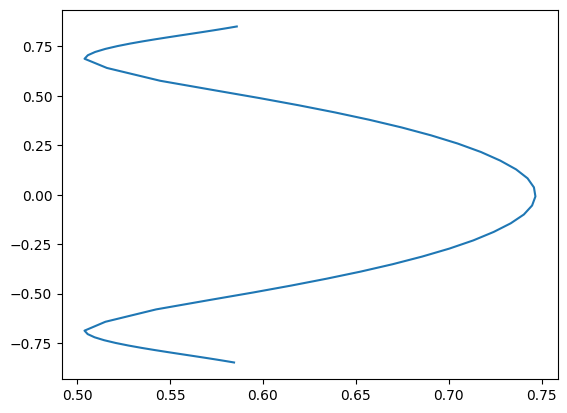

In [42]:
plt.plot(df["R"], df["Z"])
